# I/O Performance for Versioned-HDF5 Files

For these tests, we have generated `.h5` data files using the `generate_data_deterministic.py` script from the repository, using the standard options ([see details here](#standard))

# Setup

The path to the generated test files is

In [1]:
path = "/home/melissa/projects/versioned-hdf5/analysis" # change this as necessary

In [2]:
%matplotlib inline
import sys
sys.path.append('..')
import time
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
from versioned_hdf5 import VersionedHDF5File
from generate_data_deterministic import TestVersionedDatasetPerformance

# Test 1: Large Fraction Changes (Sparse)

In [3]:
testname = "test_large_fraction_changes_sparse"

## Creating files

First, we'll compute the time required to create a file with the required number of versions. For this test, we'll create files with the number of transactions listed in the `num_transactions` list below (change values as desired, but beware that for large numbers of versions the time required to create the files will be large, as well as the size of the generated files.)

In [4]:
num_transactions = [50, 100, 500, 1000]

In [5]:
t_write = []
for n in num_transactions:
    t0 = time.time()
    TestVersionedDatasetPerformance().test_large_fraction_changes_sparse(n)
    t = time.time()-t0
    t_write.append(t)

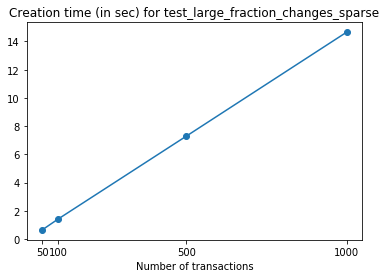

In [6]:
%matplotlib inline
plt.plot(num_transactions, t_write, 'o-')
plt.xticks(num_transactions)
plt.title("Creation time (in sec) for test_large_fraction_changes_sparse")
plt.xlabel("Number of transactions")
plt.show()

From the graph, we can see that the time grows linearly with the number of versions.

## Reading in sequential mode

For this test, we'll read data from all versions in a file, sequentially. 

In [7]:
def read_times(n, testname):
    filename = f"{testname}_{n}.h5"
    h5pyfile = h5py.File(filename, 'r+')
    vfile = VersionedHDF5File(h5pyfile)
    t0 = time.time()
    for vname in vfile._versions:
        if vname != '__first_version__':
            version = vfile[vname]
            group_key = list(version.keys())[0]
            val = version[group_key]['val']
    t = time.time()-t0
    h5pyfile.close()
    return t

In [8]:
t_read = []
for n in num_transactions:
    t = read_times(n, testname)
    t_read.append(t)
    print(f"File with {n} versions: {t} seconds.")

File with 50 versions: 0.0676720142364502 seconds.
File with 100 versions: 0.09627628326416016 seconds.
File with 500 versions: 0.48458170890808105 seconds.
File with 1000 versions: 1.3168206214904785 seconds.


As expected, read times increase for files with a larger number of versions, but the growth is close to linear.

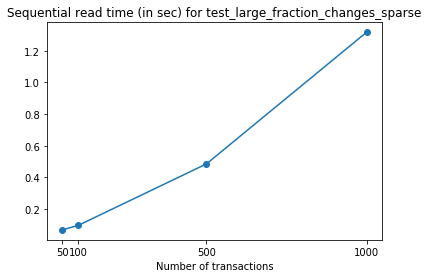

In [9]:
plt.plot(num_transactions, t_read, 'o-')
plt.xticks(num_transactions)
plt.title("Sequential read time (in sec) for test_large_fraction_changes_sparse")
plt.xlabel("Number of transactions")
plt.show()

As a summary, we can compare read and write times for the entire file.

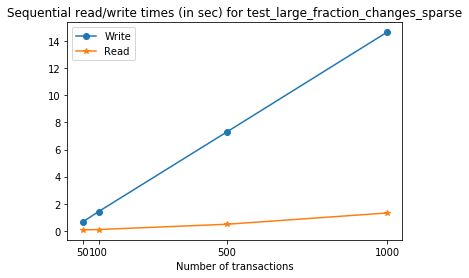

In [10]:
plt.plot(num_transactions, t_write, 'o-')
plt.plot(num_transactions, t_read, '*-')
plt.xticks(num_transactions)
plt.title("Sequential read/write times (in sec) for test_large_fraction_changes_sparse")
plt.xlabel("Number of transactions")
plt.legend(['Write', 'Read'])
plt.show()

## Adding new version to existing set

Now, we'll measure how the time required to add a new version to an existing file. The arrays to be added as a new group to the existing versioned-hdf5 file has size `num_rows_initial`, where

In [11]:
num_rows_initial = 5000

which is the size of the arrays in the initial version on this file.

In [12]:
def add_version(n, testname, num_rows_initial):
    filename = f"{testname}_{n}.h5"
    h5pyfile = h5py.File(filename, 'r+')
    vfile = VersionedHDF5File(h5pyfile)
    tt = datetime.datetime.utcnow()
    with vfile.stage_version(str(tt)) as group:
        key0 = group.create_dataset(testname + '/key0', data=np.random.rand(num_rows_initial), dtype=(np.dtype('int64')))
        key1 = group.create_dataset(testname + '/key1', data=np.random.rand(num_rows_initial), dtype=(np.dtype('int64')))
        val = group.create_dataset(testname + '/val', data=np.random.rand(num_rows_initial), dtype=(np.dtype('float64')))
    h5pyfile.close()

In [13]:
for n in num_transactions:
    t0 = time.time()
    add_version(n, testname, num_rows_initial)
    t = time.time()-t0
    print(f"File with {n} versions: {t} seconds.")

File with 50 versions: 0.07125639915466309 seconds.
File with 100 versions: 0.04468488693237305 seconds.
File with 500 versions: 0.04682493209838867 seconds.
File with 1000 versions: 0.051223039627075195 seconds.


From these tests, we can see that there's no change in the time required to add a new version with respect to the number of versions already in this file. 

## Reading specific version

For this test, we'll compute the times required to read a specific version from the versioned-hdf5 file. 

**Note**. Although possible, it is not recommended to read versions using integer indexing as the performance of reading versions from their name it far superior.

In [14]:
def read_version(n, testname):
    # Open file to read version
    filename = f"{testname}_{n}.h5"
    h5pyfile = h5py.File(filename, 'r+')
    vfile = VersionedHDF5File(h5pyfile)
    # Choose a version at random from the current file and 
    # read its version name.
    N = len(vfile._versions.keys())
    index = np.random.randint(0, N)
    vname = list(vfile._versions.keys())[index]
    if vname != '__first_version__':
        t0 = time.time()
        version = vfile[vname]
        group_key = list(version.keys())[0]
        val = version[group_key]['val']
        t = time.time()-t0
    h5pyfile.close()
    return t

In [15]:
for n in num_transactions:
    t = read_version(n, testname)
    print(f"File with {n} versions: {t} seconds.")    

File with 50 versions: 0.0012540817260742188 seconds.
File with 100 versions: 0.0010998249053955078 seconds.
File with 500 versions: 0.0022394657135009766 seconds.
File with 1000 versions: 0.0012271404266357422 seconds.


From this test, it is clear that reading an arbitrary version from the file is not affected by the number of versions in the file.

# Test 2: Mostly appends (Sparse)

In [16]:
testname = "test_mostly_appends_sparse"

## Creating files

We'll compute the time required to create a file with the numbers of versions listed in 

In [17]:
num_transactions = [50, 100, 200, 500]

In [18]:
t_write = []
for n in num_transactions:
    t0 = time.time()
    TestVersionedDatasetPerformance().test_mostly_appends_sparse(n)
    t = time.time()-t0
    t_write.append(t)

To see the behaviour here, we have plotted the observed creation times (in a blue line with circles) and a quadratic function (in an orange solid line):

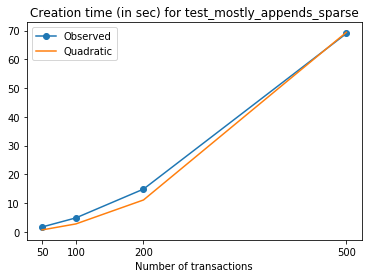

In [19]:
%matplotlib inline
plt.plot(num_transactions, t_write, 'o-')
plt.plot(num_transactions, (np.array(num_transactions)/60)**2)
plt.legend(["Observed", "Quadratic"])
plt.xticks(num_transactions)
plt.title("Creation time (in sec) for test_mostly_appends_sparse")
plt.xlabel("Number of transactions")
plt.show()

From the graph, we can see that the observed creation times are compatible with a quadratic behaviour on the number of transactions.

## Reading in sequential mode

If we read data from each version of the file, sequentially, we obtain the following:

In [20]:
t_read = []
for n in num_transactions:
    t = read_times(n, testname)
    t_read.append(t)
    print(f"File with {n} versions: {t} seconds.")

File with 50 versions: 0.0885767936706543 seconds.
File with 100 versions: 0.17311620712280273 seconds.
File with 200 versions: 0.5031108856201172 seconds.
File with 500 versions: 2.241720199584961 seconds.


Again, as we expected, read times increase (this time, quadratically) with the increase in the number of versions.

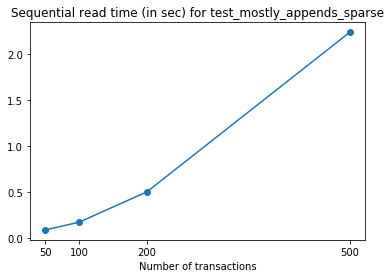

In [21]:
plt.plot(num_transactions, t_read, 'o-')
plt.xticks(num_transactions)
plt.title("Sequential read time (in sec) for test_mostly_appends_sparse")
plt.xlabel("Number of transactions")
plt.show()

As a summary, we can compare read and write times for the entire file.

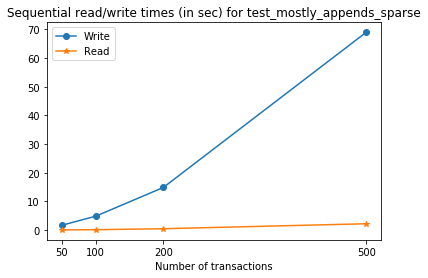

In [22]:
plt.plot(num_transactions, t_write, 'o-')
plt.plot(num_transactions, t_read, '*-')
plt.xticks(num_transactions)
plt.title("Sequential read/write times (in sec) for test_mostly_appends_sparse")
plt.xlabel("Number of transactions")
plt.legend(['Write', 'Read'])
plt.show()

## Adding new version to existing set

Now, we'll consider adding a new version to an existing file for this test.

In [23]:
num_rows_initial = 1000

In [24]:
for n in num_transactions:
    t0 = time.time()
    add_version(n, testname, num_rows_initial)
    t = time.time()-t0
    print(f"File with {n} versions: {t} seconds.")

File with 50 versions: 0.04441642761230469 seconds.
File with 100 versions: 0.05258655548095703 seconds.
File with 200 versions: 0.09146809577941895 seconds.
File with 500 versions: 0.30651235580444336 seconds.


For this test, we can see a slight increase in the time needed to add a new version.

## Reading specific version

Now, let's see the times required to read a specific version from each file.

In [25]:
for n in num_transactions:
    t = read_version(n, testname)
    print(f"File with {n} versions: {t} seconds.")

File with 50 versions: 0.0016074180603027344 seconds.
File with 100 versions: 0.002946138381958008 seconds.
File with 200 versions: 0.0023736953735351562 seconds.
File with 500 versions: 0.0013647079467773438 seconds.


Similarly to what we observed in the first example, the number of versions in the file does not affect the time needed to read a specific version.

# Test 3: Small Fraction Changes (Sparse)

In [26]:
testname = "test_small_fraction_changes_sparse"

## Creating files

Proceeding like before, we'll time the creation of files for 

In [27]:
num_transactions = [50, 100, 500, 1000]

In [28]:
t_write = []
for n in num_transactions:
    t0 = time.time()
    TestVersionedDatasetPerformance().test_small_fraction_changes_sparse(n)
    t = time.time()-t0
    t_write.append(t)

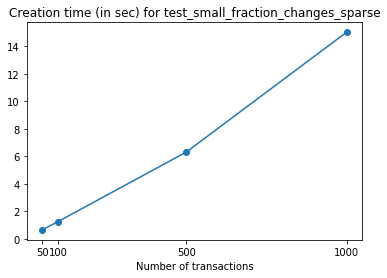

In [29]:
%matplotlib inline
plt.plot(num_transactions, t_write, 'o-')
plt.xticks(num_transactions)
plt.title("Creation time (in sec) for test_small_fraction_changes_sparse")
plt.xlabel("Number of transactions")
plt.show()

Once more, the creation times grow linearly with the number of versions in the file.

## Reading in sequential mode

In [30]:
t_read = []
for n in num_transactions:
    t = read_times(n, testname)
    t_read.append(t)
    print(f"File with {n} versions: {t} seconds.")

File with 50 versions: 0.06287860870361328 seconds.
File with 100 versions: 0.09645891189575195 seconds.
File with 500 versions: 0.6907975673675537 seconds.
File with 1000 versions: 1.5450971126556396 seconds.


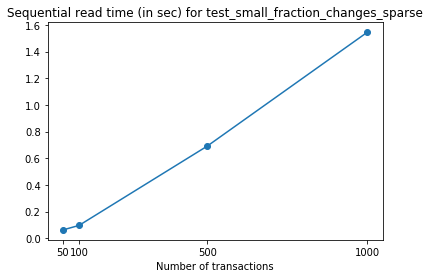

In [31]:
plt.plot(num_transactions, t_read, 'o-')
plt.xticks(num_transactions)
plt.title("Sequential read time (in sec) for test_small_fraction_changes_sparse")
plt.xlabel("Number of transactions")
plt.show()

Summarizing, we compare read and write times for the entire file for this example.

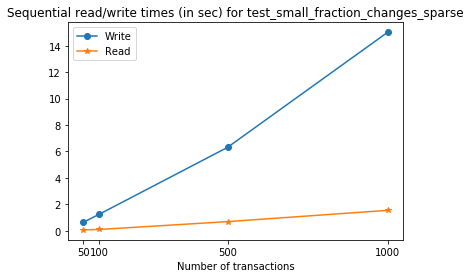

In [32]:
plt.plot(num_transactions, t_write, 'o-')
plt.plot(num_transactions, t_read, '*-')
plt.xticks(num_transactions)
plt.title("Sequential read/write times (in sec) for test_small_fraction_changes_sparse")
plt.xlabel("Number of transactions")
plt.legend(['Write', 'Read'])
plt.show()

## Adding new version to existing set

Now, we'll add one new version to each existing file.

In [33]:
num_rows_initial = 5000

In [34]:
for n in num_transactions:
    t0 = time.time()
    add_version(n, testname, num_rows_initial)
    t = time.time()-t0
    print(f"File with {n} versions: {t} seconds.")

File with 50 versions: 0.0980381965637207 seconds.
File with 100 versions: 0.03188800811767578 seconds.
File with 500 versions: 0.03511309623718262 seconds.
File with 1000 versions: 0.045226335525512695 seconds.


In this case, there is no change in the time required to add a new version to an existing file.

## Reading specific version

The times required to read a specific version from each file are similarly unnaffected by the number of existing versions in the file.

In [35]:
for n in num_transactions:
    t = read_version(n, testname)
    print(f"File with {n} versions: {t} seconds.")    

File with 50 versions: 0.001249074935913086 seconds.
File with 100 versions: 0.0010352134704589844 seconds.
File with 500 versions: 0.001645803451538086 seconds.
File with 1000 versions: 0.0015478134155273438 seconds.


# Test 4: Mostly appends (Dense)

Finally, we test

In [36]:
testname = "test_mostly_appends_dense"

## Creating files

We'll create files with the following numbers of versions:

In [37]:
num_transactions = [50, 100, 200, 500]

In [38]:
t_write = []
for n in num_transactions:
    t0 = time.time()
    TestVersionedDatasetPerformance().test_mostly_appends_dense(n)
    t = time.time()-t0
    t_write.append(t)

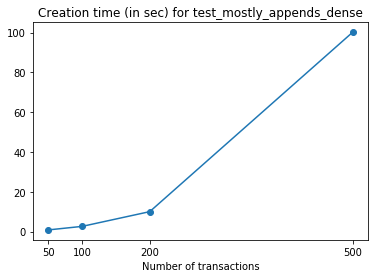

In [39]:
%matplotlib inline
plt.plot(num_transactions, t_write, 'o-')
plt.xticks(num_transactions)
plt.title("Creation time (in sec) for test_mostly_appends_dense")
plt.xlabel("Number of transactions")
plt.show()

This behaviour is very similar to the one observed for `test_mostly_appends_sparse`. It is quadratic with respect to the number of versions for each file.

## Reading in sequential mode

In [40]:
t_read = []
for n in num_transactions:
    t = read_times(n, testname)
    t_read.append(t)
    print(f"File with {n} versions: {t} seconds.")

File with 50 versions: 0.08984661102294922 seconds.
File with 100 versions: 0.17216753959655762 seconds.
File with 200 versions: 0.6314949989318848 seconds.
File with 500 versions: 6.160452842712402 seconds.


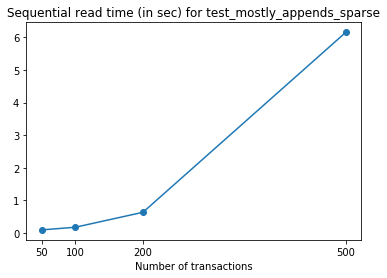

In [41]:
plt.plot(num_transactions, t_read, 'o-')
plt.xticks(num_transactions)
plt.title("Sequential read time (in sec) for test_mostly_appends_sparse")
plt.xlabel("Number of transactions")
plt.show()

Once again, we can see a quadratic behaviour on the graph, which is expected from the file sizes and the size of the arrays on each file.

As a summary, we can compare read and write times for the entire file.

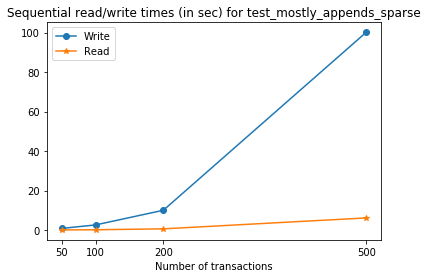

In [42]:
plt.plot(num_transactions, t_write, 'o-')
plt.plot(num_transactions, t_read, '*-')
plt.xticks(num_transactions)
plt.title("Sequential read/write times (in sec) for test_mostly_appends_sparse")
plt.xlabel("Number of transactions")
plt.legend(['Write', 'Read'])
plt.show()

## Adding new version to existing set

Using the standard parameter

In [43]:
num_rows_initial = 30

we can see that in this case, there is also a slight increase in the time to add a new version to the existing file:

In [44]:
for n in num_transactions:
    t0 = time.time()
    add_version(n, testname, num_rows_initial)
    t = time.time()-t0
    print(f"File with {n} versions: {t} seconds.")

File with 50 versions: 0.033867835998535156 seconds.
File with 100 versions: 0.044382572174072266 seconds.
File with 200 versions: 0.07331562042236328 seconds.
File with 500 versions: 0.48027825355529785 seconds.


## Reading specific version

Reading a specific version from this set also seems to show a slight increase in time with respect to the existing number of versions:

In [45]:
for n in num_transactions:
    t = read_version(n, testname)
    print(f"File with {n} versions: {t} seconds.")

File with 50 versions: 0.0016345977783203125 seconds.
File with 100 versions: 0.0022704601287841797 seconds.
File with 200 versions: 0.009861230850219727 seconds.
File with 500 versions: 0.053418874740600586 seconds.


# Summary

- `test_mostly_appends_sparse` and `test_mostly_appends_dense` show a quadratic behaviour with respect to file creation and sequential read times, while `test_large_fraction_changes_sparse` and `test_small_fraction_changes_sparse` show a linear behaviour in those same tests. This reflects what we observe in file sizes and can be partially explained by the increase in the dimension of the arrays which are stored at each version.
- Adding new versions and reading specific versions (by version name) from an existing file is almost unnaffected by the number of existing versions in each file. However, more tests are needed for a more robust conclusion.

<a id='standard'></a>
## Standard parameters

- `test_large_fraction_changes_sparse`: 
    - `num_rows_initial = 5000`
    - `num_rows_per_append = 10`
    - `num_inserts = 10`
    - `num_deletes = 10`
    - `num_changes = 1000`
- `test_small_fraction_changes_sparse`
    - `num_rows_initial = 5000`
    - `num_rows_per_append = 10`
    - `num_inserts = 10`
    - `num_deletes = 10`
    - `num_changes = 10`
- `test_mostly_appends_sparse`:
    - `num_rows_initial = 1000`
    - `num_rows_per_append = 1000`
    - `num_inserts = 10`
    - `num_deletes = 10`
    - `num_changes = 10`  
- `test_mostly_appends_dense`
    - `num_rows_initial_0 = 30`
    - `num_rows_initial_1 = 30`
    - `num_rows_per_append_0 = 1`
    - `num_inserts_0 = 1`
    - `num_inserts_1 = 10`
    - `num_deletes_0 = 1`
    - `num_deletes_1 = 1`
    - `num_changes = 10`